In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import sys

sys.path.append("../..")
from src.utils.constants import OPENPOSE_ANGLES

In [55]:
joints_df = pd.read_csv("../../data/test/joints/squat.csv")
joints_df.head()

,rep,frame,x,y,z,joint_name,label
0,1,0,-0.009605,5.847544e-02,0.266672,nose,correct
1,1,0,-0.005161,1.734723e-18,0.195177,upper_spine,correct
2,1,0,-0.065790,1.667699e-03,0.195600,right_shoulder,correct
3,1,0,-0.071763,-2.143492e-02,0.095677,right_arm,correct
4,1,0,-0.074851,-2.198233e-02,-0.001004,right_wrist,correct


In [56]:
for _, rep in joints_df.groupby(["label", "rep"]):
    rep = rep.reset_index()
    if rep["label"].loc[0] == "correct":
        correct = rep
    else:
        incorrect = rep

In [57]:
from src.utils.data import joints_rep_df_to_numpy, get_angles_from_joints


correct_joints = joints_rep_df_to_numpy(correct)
correct_angles = get_angles_from_joints(correct_joints, OPENPOSE_ANGLES)

incorrect_joints = joints_rep_df_to_numpy(incorrect)
incorrect_angles = get_angles_from_joints(incorrect_joints, OPENPOSE_ANGLES)

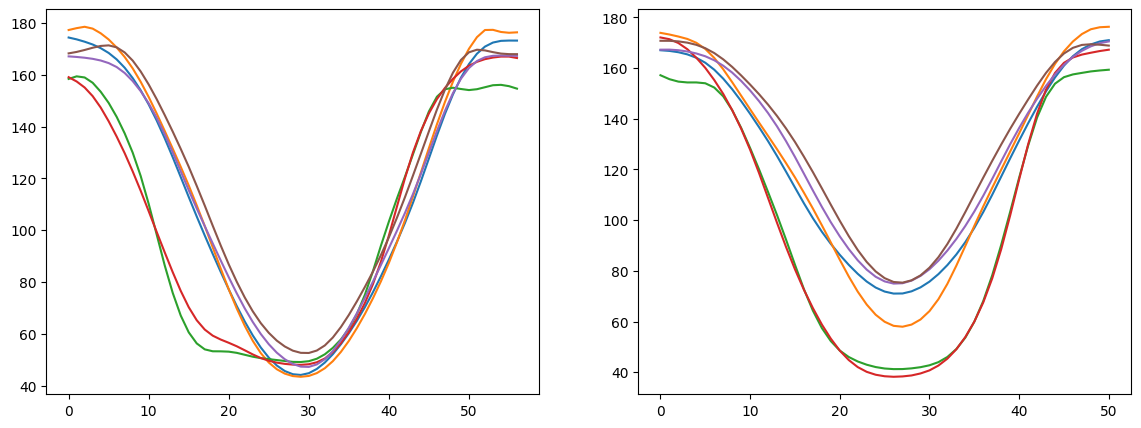

In [5]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 5))
axes[0].plot(correct_angles.values)
axes[1].plot(incorrect_angles.values);

In [6]:
rep_signal = correct_angles.mean(axis=1)
zero_point = np.mean(rep_signal)

In [7]:
def segment_signal(
    x: pd.DataFrame, important_angles: list[str], sliding_window_size: int = 5
) -> pd.DataFrame:
    x = x[important_angles]
    rep_signal = x.mean(axis=1)
    zero_point = np.mean(rep_signal)

    variances = []
    for idx in range(0, len(rep_signal) - sliding_window_size + 1, 1):
        window = rep_signal[idx : idx + sliding_window_size]
        variances.append(np.std(window))
    variances = np.array(variances)

    below_mean_indexes = np.where(rep_signal < zero_point)[0]
    above_mean_indexes = np.where(rep_signal > zero_point)[0]

    mid_phase_idx = (
        below_mean_indexes[np.argmin(variances[below_mean_indexes])]
        + sliding_window_size // 2
    )
    above_mean_indexes_left = above_mean_indexes[above_mean_indexes < mid_phase_idx]
    start_phase_idx = (
        above_mean_indexes_left[np.argmin(variances[above_mean_indexes_left])]
        + sliding_window_size // 2
    )

    above_mean_indexes_right = above_mean_indexes[above_mean_indexes > mid_phase_idx]
    above_mean_indexes_right = above_mean_indexes_right[
        above_mean_indexes_right < len(variances)
    ]
    finish_phase_idx = (
        above_mean_indexes_right[np.argmin(variances[above_mean_indexes_right])]
        + sliding_window_size // 2
    )
    return x.iloc[[start_phase_idx, mid_phase_idx, finish_phase_idx]]

In [8]:
import yaml

with open(f"../../configs/squat.yaml", "r") as file:
    file_data = yaml.safe_load(file)
    important_angles = file_data["important_angles"]
    reference_table = pd.DataFrame(file_data["reference_table"]).transpose()

In [9]:
phases_names = reference_table.index.values

In [10]:
phases = segment_signal(correct_angles, important_angles)

In [54]:
phases

,left_knee,right_knee,left_hip,right_hip
0,172.720514,178.480007,166.538742,169.532438
1,44.142226,43.436095,47.350133,52.671426
2,173.048614,176.475445,167.378977,168.139400


In [11]:
reference_table = reference_table.reset_index(drop=True)
reference_table

,left_knee,right_knee,left_hip,right_hip
0,180,180,180,180
1,70,70,90,90
2,180,180,180,180


In [12]:
phases = phases.reset_index(drop=True)
phases

,left_knee,right_knee,left_hip,right_hip
0,172.720514,178.480007,166.538742,169.532438
1,44.142226,43.436095,47.350133,52.671426
2,173.048614,176.475445,167.378977,168.139400


In [13]:
results = reference_table - phases

In [14]:
results["phase"] = phases_names
results = results.set_index("phase")

In [15]:
results

,left_knee,right_knee,left_hip,right_hip
phase,,,,
start,7.279486,1.519993,13.461258,10.467562
mid,25.857774,26.563905,42.649867,37.328574
finish,6.951386,3.524555,12.621023,11.860600


In [17]:
from tslearn.metrics import dtw_path

reference = correct_angles["left_hip"]
query = incorrect_angles["left_hip"]

path, score = dtw_path(reference, query)
path = np.array(path)

In [18]:
reference_to_query = path[:, 0]
query_to_reference = path[:, 1]

In [19]:
def filter_repetable_reference_indexes(
    referene_to_query: np.ndarray, query_to_refernce: np.ndarray
) -> np.ndarray:
    query_to_refernce_cp = query_to_refernce.copy()

    for idx in range(len(referene_to_query) - 1, -1, -1):
        if idx > 0 and referene_to_query[idx] == referene_to_query[idx - 1]:
            query_to_refernce_cp = np.delete(query_to_refernce_cp, idx)

    return query_to_refernce_cp

In [20]:
query_to_reference_idx = filter_repetable_reference_indexes(
    reference_to_query, query_to_reference
)
query_to_reference_warped = np.array([query[idx] for idx in query_to_reference_idx])

80.89727910176374

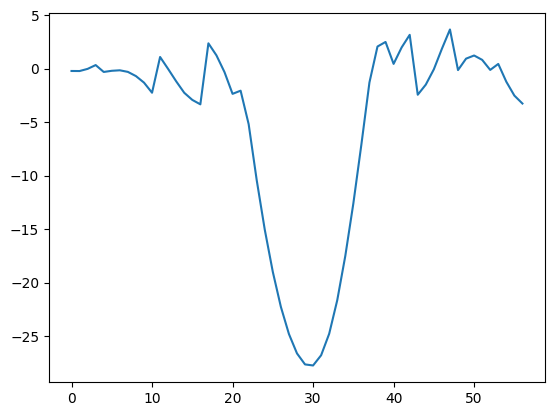

In [21]:
plt.plot(reference - query_to_reference_warped)
score